In [1]:
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import imageio

import pandas as pd

%matplotlib inline

### Data preprocessing

In [2]:
# For load estimation

path = r'D:\GitHub\EMG_regressive_model\data\2'
all_files = glob.glob(path + "/*csv")
dfList = []

for filename in all_files:
    df = pd.read_csv(filename)
    df.head()
    dfList.append(df)
frame = pd.concat(dfList, axis = 1, ignore_index = False)
frame.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,joint_angle
0,0.000000,0.000000,0.000017,0.001201,0.000000,0.002466,2.690000e-06,0.000000e+00,0.000011,0.25,0.666667,0.0,0.5,1.0,0.0,1.195211
1,0.001852,0.000148,0.001041,0.004637,0.000448,0.013558,2.840000e-05,4.030000e-07,0.000208,0.00,0.000000,0.0,0.0,0.0,0.5,1.190142
2,0.004361,0.000536,0.010023,0.003521,0.000924,0.017291,1.720000e-05,5.460000e-07,0.000349,0.00,0.333333,0.0,0.0,0.0,0.0,1.185074
3,0.005189,0.000417,0.008359,0.000692,0.002204,0.025504,8.370000e-07,4.080000e-06,0.000714,0.25,0.333333,0.0,0.0,0.5,0.0,1.180009
4,0.003663,0.000805,0.008346,0.004482,0.005426,0.041961,2.580000e-05,3.220000e-05,0.001778,0.00,0.000000,0.0,0.0,0.5,0.5,1.174926


In [3]:
# create input and output data
x = frame.iloc[:, 0:-1]
y = frame.iloc[:, -1]

# split the data into train, validate, and test set
# because there is a class imblance, should use the stratify opton to make each set has identical distribution
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1)

In [4]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [5]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

### Setup the Neural Network

In [6]:
#Reproducible
torch.manual_seed(1)

### Check whether the GPU is available

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.x_data)

In [9]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(),
                                 torch.from_numpy(y_train).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(),
                                torch.from_numpy(y_test).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(),
                               torch.from_numpy(y_val).float())

### Build the feedforward neural network

In [10]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        
        return x
    
    def predict(self, test_inputs):
        x = self.relu(self.fc1(test_inputs))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        
        return x
        
        

In [11]:
EPOCHS = 150
BATCH_SIZE = 1
LEARNING_RATE = 0.001
NUM_FEATURES = len(x.columns)

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [13]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

MultipleRegression(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
# Define a dictionary which will store the loss / epoch for both train and validation sets
loss_stats = {
    'train':[],
    'val':[]
}

### Train the network

In [15]:
print('=========Begin Training=========')
for e in range(1, EPOCHS+1):
    
    #TRAINING
    train_epoch_loss = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
    
    #VALIDATION
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['val'].append(val_epoch_loss / len(val_loader))
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    
    

=========Begin Training=========
Epoch 001: | Train Loss: 2414.69449 | Val Loss: 2150.98090
Epoch 002: | Train Loss: 2014.97834 | Val Loss: 2062.44646
Epoch 003: | Train Loss: 1958.61181 | Val Loss: 1953.99220
Epoch 004: | Train Loss: 1886.48849 | Val Loss: 1909.29521
Epoch 005: | Train Loss: 1843.19790 | Val Loss: 1803.43370
Epoch 006: | Train Loss: 1791.13093 | Val Loss: 1856.50688
Epoch 007: | Train Loss: 1759.51733 | Val Loss: 1703.25730
Epoch 008: | Train Loss: 1726.60880 | Val Loss: 1925.28699
Epoch 009: | Train Loss: 1692.57221 | Val Loss: 1725.88783
Epoch 010: | Train Loss: 1660.00641 | Val Loss: 1642.45264
Epoch 011: | Train Loss: 1621.90035 | Val Loss: 1711.50716
Epoch 012: | Train Loss: 1612.75083 | Val Loss: 1688.83759
Epoch 013: | Train Loss: 1592.70862 | Val Loss: 1727.87130
Epoch 014: | Train Loss: 1583.81696 | Val Loss: 1611.55417
Epoch 015: | Train Loss: 1568.55149 | Val Loss: 1608.82995
Epoch 016: | Train Loss: 1559.09909 | Val Loss: 1648.70178
Epoch 017: | Train Loss

### Post processing
1. Vsiualize loss and accuracy
2. Test trained model

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

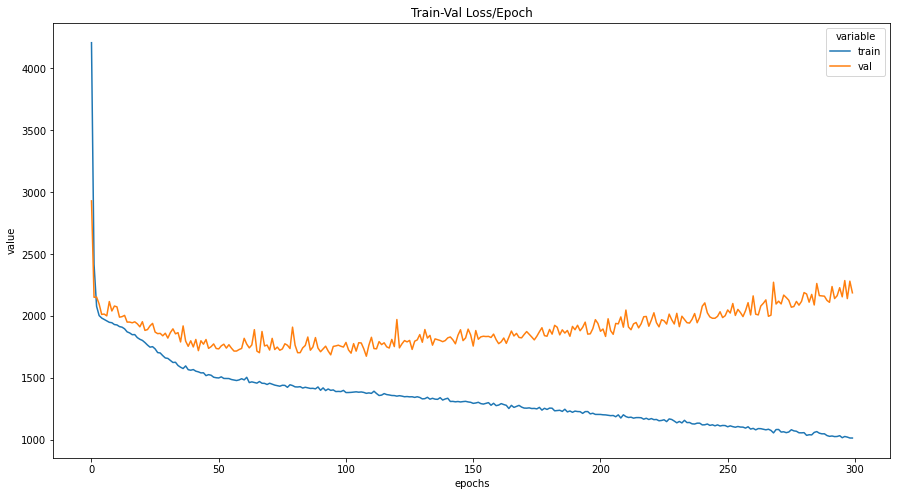

In [151]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [152]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

In [153]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [154]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 1869.701144728248
R^2 : 0.4007045328591635
